In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from sklearn.cross_validation import cross_val_predict

from sklearn.pipeline import Pipeline

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
#import xgboost as xgb

# default colours for prettier plots

col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

,Age,Allegiance,Also known as,Appeared in,Culture,Date of birth,Death,Family,First seen,Last seen,...,Religion,Season(s),Status,Titles,Background,Season 1,Season 2,Season 3,Season 4,Season 5
Amaya,NaN,House Forrester,NaN,2 episodes,NaN,NaN,Shot in the head with an arrow during the Batt...,NaN,"""A Nest of Vipers""","""The Ice Dragon""",...,NaN,Game of Thrones: A Telltale Games Series,Deceased,NaN,"When Beskha was still a slave, she and Amaya ...",NaN,NaN,NaN,NaN,NaN
Andros,NaN,House Whitehill,NaN,3 episode,NaN,NaN,Beheaded for treason,Unnamed - wife,"""The Lost Lords""","""The Ice Dragon""",...,NaN,Game of Thrones: A Telltale Games Series,Deceased,Lord,NaN,NaN,NaN,NaN,NaN,NaN
Arthur_Glenmore,NaN,House GlenmoreHouse Forrester(briefly),Quiver,2 episodes,NaN,NaN,Tortured and disemboweled by Ramsay Snow.,Lord Glenmore - fatherElaena Glenmore - sister,"""Sons of Winter""","""A Nest of Vipers""",...,NaN,Game of Thrones: A Telltale Games Series,Deceased,NaN,"As a youth, on the day he learned to hold a b...",NaN,NaN,NaN,NaN,NaN
Asher_Forrester,NaN,House Forrester,NaN,5 episodes,Northmen,NaN,"Shot and stabbed by Whitehill soldiers, then f...",{Gregor Forrester} - father {Elissa Forrester}...,"""The Lost Lords""","""The Ice Dragon"" (head of corpse, player-deter...",...,NaN,Game of Thrones: A Telltale Games Series,Determinant,Lord of Ironrath (player-determined)Defender o...,Asher had always been a rebellious youth bra...,NaN,NaN,NaN,NaN,NaN
Bezzaq,NaN,Wise Masters,NaN,1 episode,NaN,NaN,Throat slit by Tazal,NaN,"""The Lost Lords""","""The Lost Lords""",...,NaN,Game of Thrones: A Telltale Games Series,Deceased,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bloodsong,NaN,NaN,NaN,1 or 2 episodes,NaN,NaN,Stabbed through the chest by Asher Forrester o...,NaN,"""A Nest of Vipers""","""A Nest of Vipers or ""The Ice Dragon",...,NaN,Game of Thrones: A Telltale Games Series,Determinant,NaN,Not much is known about Bloodsong other than ...,NaN,NaN,NaN,NaN,NaN
Bowen_(Squire),NaN,House Forrester,NaN,1 or 2 episodes,Northmen,NaN,Stabbed in the neck by a soldier of House Frey...,NaN,"""Iron From Ice""","""Iron From Ice"" or ""The Ice Dragon""",...,NaN,Game of Thrones: A Telltale Games Series,Determinant,Squire,"Bowen became the squire of Norren, a respecta...",NaN,NaN,NaN,NaN,NaN
Branfield_(Lord),NaN,House BranfieldHouse Targaryen,NaN,NaN,NaN,NaN,NaN,{Talia Branfield} - wife{Elissa Forrester} - d...,NaN,NaN,...,NaN,Game of Thrones: A Telltale Games Series,Deceased,NaN,Lord Branfield was a Targaryen loyalist and f...,NaN,NaN,NaN,NaN,NaN
Casper,NaN,The Night's Watch,NaN,2 episodes,NaN,NaN,NaN,NaN,"""The Lost Lords""","""The Sword in the Darkness""",...,NaN,Game of Thrones: A Telltale Games Series,Uncertain,Builder,NaN,NaN,NaN,NaN,NaN,NaN
Cedric_Forrester,NaN,House Forrester,NaN,NaN,Northmen,NaN,NaN,{Unnamed triplets} - Sons,NaN,NaN,...,Old Gods of the Forest,Game of Thrones: A Telltale Games Series,Deceased,Lord of Ironrath,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# read data from the got-data.ipynb file
# most of it is scrapped from the game of thrones tv show wiki
df = pd.read_csv('data/got_data_all_characters.csv', sep=',', index_col=0)

# who do we not have data for?
idxRemove = (df['Season(s)'].isnull())
print('Never appeared... ({} characters)'.format(np.sum(idxRemove)))
print(df[idxRemove].index)
# delete people with no data - they have no scores and never appeared in any season
df = df.loc[~idxRemove]


# remove video game characters
idxRemove = [i for i, s in enumerate(df['Season(s)']) if 'A Telltale Games Series' in s]
print('\nVideo games... ({} characters)'.format(len(idxRemove)))
print(df.iloc[idxRemove].index)
df = df.iloc[ [i for i in range(df.shape[0]) if i not in idxRemove]  ]

# pick all who survived past season 1 - this filters a lot of background characters
idxRemove = (df['Status'].values == 'Deceased') & (df['Season(s)'].values == '1')
df = df.loc[~idxRemove]
print('\nDeleting {} who died on/before season 1. Ned :('.format(np.sum(idxRemove)))


# print out the data we have
print('Total of {} characters.'.format(df.shape[0]))
df.head(n=3).T

Never appeared... (18 characters)
Index([u'<td width="33.3%"><h3>T cont.</h3>', u'Aegon_II_Targaryen',
       u'Alannys_Greyjoy', u'Alerie_Tyrell', u'Alicent_Hightower',
       u'Alys_Arryn', u'Aya', u'Domeric_Bolton', u'First_King', u'Florian',
       u'Jasper_Arryn', u'Knight_of_the_Laughing_Tree', u'Luthor_Tyrell',
       u'Recast_characters', u'Rhaenys_Targaryen_(daughter_of_Rhaegar)',
       u'Ronnel_Arryn', u'The_Prince_That_Was_Promised', u'Willem'],
      dtype='object')

Video games... (72 characters)
Index([u'Amaya', u'Andros', u'Arthur_Glenmore', u'Asher_Forrester', u'Bezzaq',
       u'Bloodsong', u'Bowen_(Squire)', u'Branfield_(Lord)', u'Casper',
       u'Cedric_Forrester', u'Corlys_Wells', u'Cotter', u'Croft', u'Damien',
       u'Denner_Frostfinger', u'Dezhor_zo_Raza', u'Duff', u'Duncan_Tuttle',
       u'Ebbert_Whitehill', u'Elaena_Glenmore', u'Elissa_Forrester',
       u'Elsera_Snow', u'Erik', u'Errold_Holt', u'Ethan_Forrester', u'Fegg',
       u'Finn', u'Gared_Tuttle', u

,Addam_Marbrand,Adrack_Humble,Aegon_III_Targaryen
Age,NaN,NaN,NaN
Allegiance,House LannisterHouse Marbrand,House GreyjoyHouse Humble,House Targaryen
Also known as,NaN,NaN,"Aegon of House Targaryen, the Third of His Nam..."
Appeared in,"""Fire and Blood""","""The Mountain and the Viper""",NaN
Culture,NaN,Ironborn,Valyrian
Date of birth,NaN,NaN,NaN
Death,NaN,Flayed by Ramsay Snow,NaN
Family,Damon Marbrand (father),NaN,{Daemon Targaryen} - father{Rhaenyra Targaryen...
First seen,NaN,NaN,NaN
Last seen,NaN,NaN,NaN


```python
# define a matrix of relationships ... realized this is harder than it looks!
# 0 - not related
# 1 - father
# 2 - mother
# 3 - sibling
# 4 - child
# 5 - other
fam = pd.DataFrame(np.zeros([df.shape[0],df.shape[0]]), index=df.index, columns=df.index)
for i, char in enumerate(fam.index):
    curr_fam = df.loc[char, 'Family']
    if curr_fam is np.nan or curr_fam is None:
        continue
    
    # otherwise, let's parse their family tree
    common_fam = [filter(lambda x: x in curr_fam, sublist) for sublist in fam.index]
    print(curr_fam)
    #print(common_fam)
    break
```

In [80]:
# define some useful subfunctions

# given a dataframe/regex phrase, this counts the number of times the regex appears
def count_words(s, phrase):
    if s is np.nan:
        return 0
    else:
        return len(re.findall(phrase,s, re.IGNORECASE))

# this calls the above function and adds the data to the given dataframe
def add_data(df_data, column_name, phrase, txt_col=None):
    if txt_col is None:
        txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
        
    df_new = df[txt_col].applymap(lambda x: count_words(x,phrase))
    df_data[column_name] = df_new[txt_col].sum(axis=1)
    return df_data

In [101]:
def add_allegiance(df, df_has_allegiance):
    
    houses = ['House Lannister', 'House Stark', 'House Targaryen', 'House Frey', 
              'House Greyjoy', "Night's Watch", 'House Martell', 'Free Folk', 'House Forrester',
              'House Bolton', 'House Baratheon', 'Kingsguard']
    
    for h in houses:
        tmp = np.zeros(df.shape[0])
        val = df_has_allegiance['Allegiance'].values
        for i in range(df.shape[0]):
            if val[i] is np.nan:
                continue
            elif h in val[i]:
                tmp[i] = 1.0
        df[h] = tmp
        
    return df
              
# only look at background // season 1
txt_col = ['Background','Season 1']

# initialize the dataframe
idxData = np.ones(df.shape[0], dtype=bool)
df_data = df.loc[idxData, ['Status']]

# start adding data based on counting the frequency of words


# count the number of hyphens as a surrogate as the number of in-show family member
# in the data, the family members appear as "sister - Sansa Stark, father - Eddard Stark," .. etc
df_data = add_data(df_data, 'family_members',' - ', txt_col = ['Family'])

df_data = add_allegiance(df_data, df)
# number of seasons the character appeared in
df_data = add_data(df_data, 'number_of_seasons','[1]', txt_col = ['Season(s)'])

# various word "types" across all the data
df_data = add_data(df_data, 'violent_words','(knight|warrior|sword|axe|spear|kill|murder|fight|assassinate)')
df_data = add_data(df_data, 'sexy_words','(sex|naked|love|slept|nude|kiss)')
df_data = add_data(df_data, 'fun_words','(beer|wine|glass|drunk|inebriate)')
df_data = add_data(df_data, 'number_of_words','\w+')

# let's remove people who weren't in any of the seasons !
idxRemove = df_data['number_of_seasons'].values == 0
df_data = df_data.loc[~idxRemove]
df_data.head()


,Status,family_members,House Lannister,House Stark,House Targaryen,House Frey,House Greyjoy,Night's Watch,House Martell,Free Folk,House Forrester,House Bolton,House Baratheon,Kingsguard,number_of_seasons,violent_words,sexy_words,fun_words,number_of_words
Addam_Marbrand,Alive,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,179
Aegon_IV_Targaryen,Deceased,16,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,131
Aegon_V_Targaryen,Deceased,14,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,415
Aemon,Deceased,12,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,2,0,1301
Aerys_II_Targaryen,Deceased,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,0,0,1096


lr         0.660961 [0.407143, 0.825]


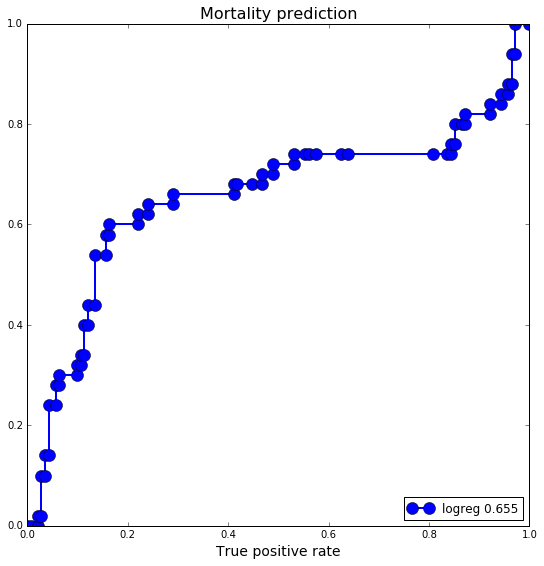

In [105]:
# prep data
X = df_data.values[:,1:df_data.shape[1]]

# alive until proven dead !
y = np.zeros(df_data.shape[0])
for i, val in enumerate(df_data['Status'].values):
    if val is None or val is np.nan:
        continue
    if 'Dead' in val:
        y[i] = 1.0
    elif 'Deceased' in val:
        y[i] = 1.0
        

# workaround cross_val_predict returning 0s/1s - calling this makes it return probabilities
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)

# cross-validation performance
mdl = "logreg"
model = LogisticRegression(fit_intercept=True)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ("lr", model)])
scores = cross_val_score(estimator, X, y, scoring='roc_auc',cv=5)
print('{:10s} {:5g} [{:5g}, {:5g}]'.format("lr", np.mean(scores), np.min(scores), np.max(scores) ))

# plot a roc curve by getting cross-validation predictions
predicted = cross_val_predict(proba_logreg(), X, y, cv=10)
predicted = predicted[:,1]

plt.figure(figsize=[9,9])
ax = plt.gca()
fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
plt.plot(fpr, tpr, 'bo-',lw=2,markersize=12,
        label=mdl + ' ' + '%0.3f' % metrics.auc(fpr, tpr))
plt.xlabel('False positive rate',fontsize=14)
plt.xlabel('True positive rate',fontsize=14)
plt.legend(loc='lower right')
plt.title('Mortality prediction',fontsize=16)
plt.show()